In [1]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [13]:
emotion_mapping = {'anger.jpg': 0, 'happiness.jpg': 1, 'sadness.jpg': 2, 'neutral.jpg': 3}

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def process_image(file_path):
    # Read the image
    image = cv2.imread(file_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if len(faces) == 0:
        return None
    # Focus on the first detected face
    (x, y, w, h) = faces[0]
    # Crop and resize the face
    face = cv2.resize(gray[y:y+h, x:x+w], (48, 48))
    # Flatten the 48x48 image into a 1D array
    pixels = face.flatten()

    return pixels

In [14]:
base_path = '../Dataset/Dataset/SZU-EmoDage'
dataset = []


for root, dirs, files in os.walk(base_path):
    for file_name in files:  
        # Check if the file is a JPEG image and the emotion is one of the ones we want
        if file_name in emotion_mapping: 
            file_path = os.path.join(root, file_name)
            pixels = process_image(file_path)
            if pixels is not None:
                dataset.append((emotion_mapping[file_name], ' '.join(map(str, pixels))))


data = pd.DataFrame(dataset, columns=['emotion', 'pixels'])

In [15]:
data.head(5)

,emotion,pixels
0,0,25 17 22 48 83 104 111 107 112 118 122 127 130...
1,6,17 24 74 95 111 123 118 120 126 130 132 132 13...
2,5,39 29 19 14 17 10 20 43 80 99 112 121 125 131 ...
3,1,30 13 15 24 25 81 103 111 117 121 125 129 131 ...
4,3,18 16 13 19 52 92 108 121 123 130 133 136 139 ...


In [16]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion

In [17]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape:", data_X.shape, dataName, "_Y shape:", data_Y.shape)
    #print(data_X) #[[[0.27450982]
    #print(data_Y) #[[1. 0. 0. ... 0. 0. 0.]
    return data_X, data_Y

In [18]:
def plot_training(results):
    fig, axes = plt.subplots(1,2, figsize=(18, 6))
    # Plot training & validation accuracy values
    axes[0].plot(results.history['acc'])
    axes[0].plot(results.history['val_acc'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(results.history['loss'])
    axes[1].plot(results.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [20]:
##Functions

#Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [21]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# early stopping
es = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)

In [22]:
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts

,emotion,count
0,0,118
1,6,118
2,5,118
3,1,119
4,3,118
5,2,118
6,4,119


In [33]:
emotion_map = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,118
1,Disgust,118
2,Fear,118
3,Happy,119
4,Neutral,118
5,Sad,118
6,Surprise,119


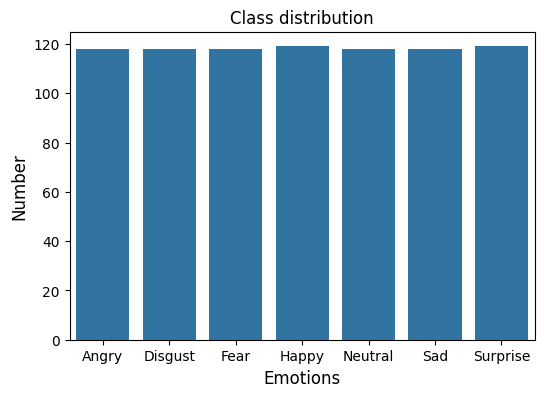

In [34]:
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [35]:
distinct_values = data['emotion'].unique()
print(distinct_values)

[0 6 5 1 3 2 4]


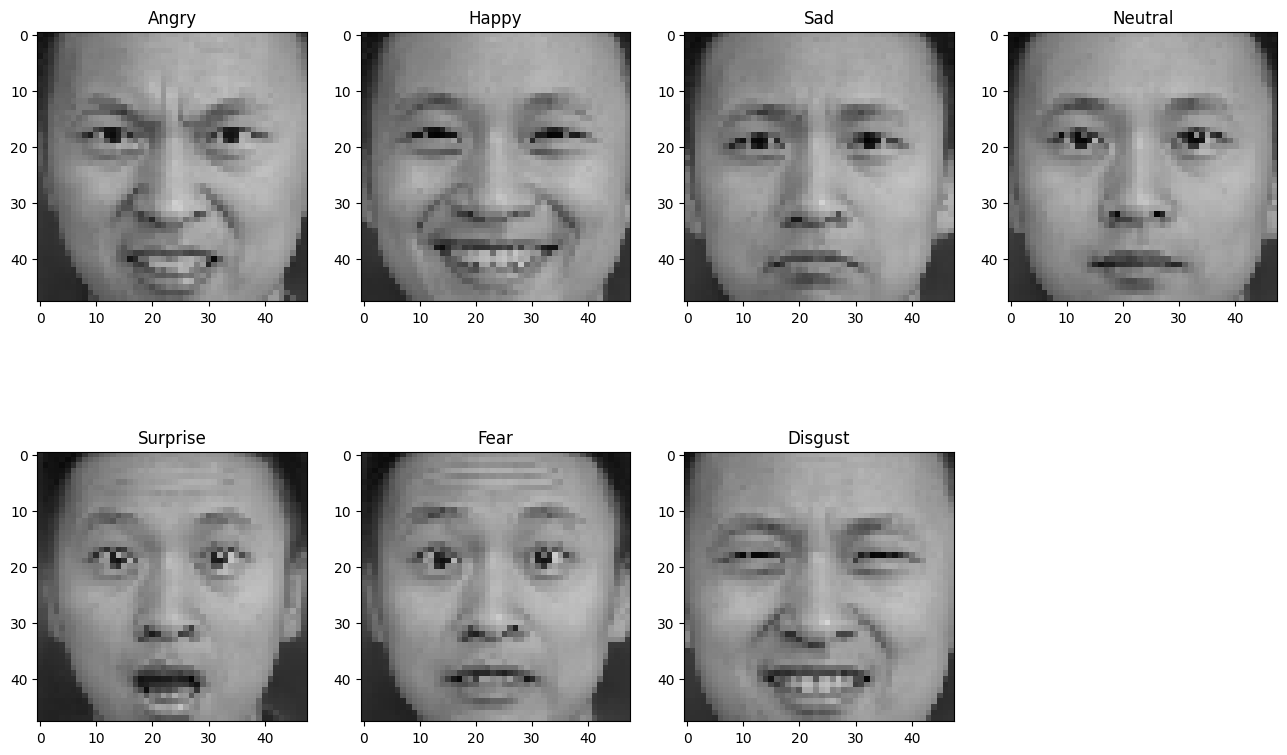

In [36]:
plt.figure(0, figsize=(16,10))
for i in range(1,5):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [269]:
emotion_map = {0: 'Angry', 1: 'Happy', 2: 'Sad',  3:'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,118
1,Happy,119
2,Neutral,118
3,Sad,118


In [270]:
data

,emotion,pixels
0,0,25 17 22 48 83 104 111 107 112 118 122 127 130...
1,1,30 13 15 24 25 81 103 111 117 121 125 129 131 ...
2,3,18 16 13 19 52 92 108 121 123 130 133 136 139 ...
3,2,21 17 15 17 17 42 74 97 113 116 122 122 126 13...
4,0,59 45 44 44 45 38 45 59 32 52 92 51 89 89 96 7...
...,...,...
468,2,38 29 28 27 33 30 31 24 30 42 45 63 79 95 116 ...
469,0,25 26 19 24 33 86 110 117 120 120 124 128 131 ...
470,1,23 18 25 24 18 22 22 16 25 50 93 116 125 132 1...
471,3,30 24 24 26 20 25 18 16 72 105 118 128 129 135...


In [271]:
data['emotion'] = data['emotion'].rank(method='dense').astype(int) - 1

In [272]:
from sklearn.model_selection import train_test_split

szu_train, remaining_df = train_test_split(data, train_size=0.8, random_state=42, stratify=data['emotion'])
szu_val, szu_test = train_test_split(remaining_df, test_size=0.5, random_state=42, stratify=remaining_df['emotion'])

In [273]:
def row3image(row, emotion_map):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion

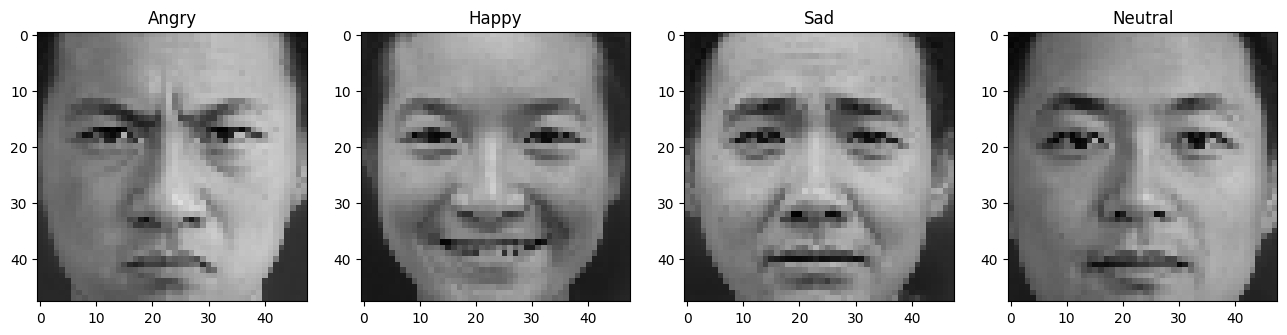

In [274]:
emotion_map = {0: 'Angry',  1: 'Happy', 2: 'Sad', 3: 'Neutral'}

plt.figure(0, figsize=(16,10))
for i in range(4):  # Adjust range to match emotion indices
    face = szu_train[szu_train['emotion'] == i].iloc[0]  # Use i directly without subtracting 1
    img = row3image(face, emotion_map)
    plt.subplot(2, 4, i+1)  # Increment i by 1 to start subplot index from 1
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

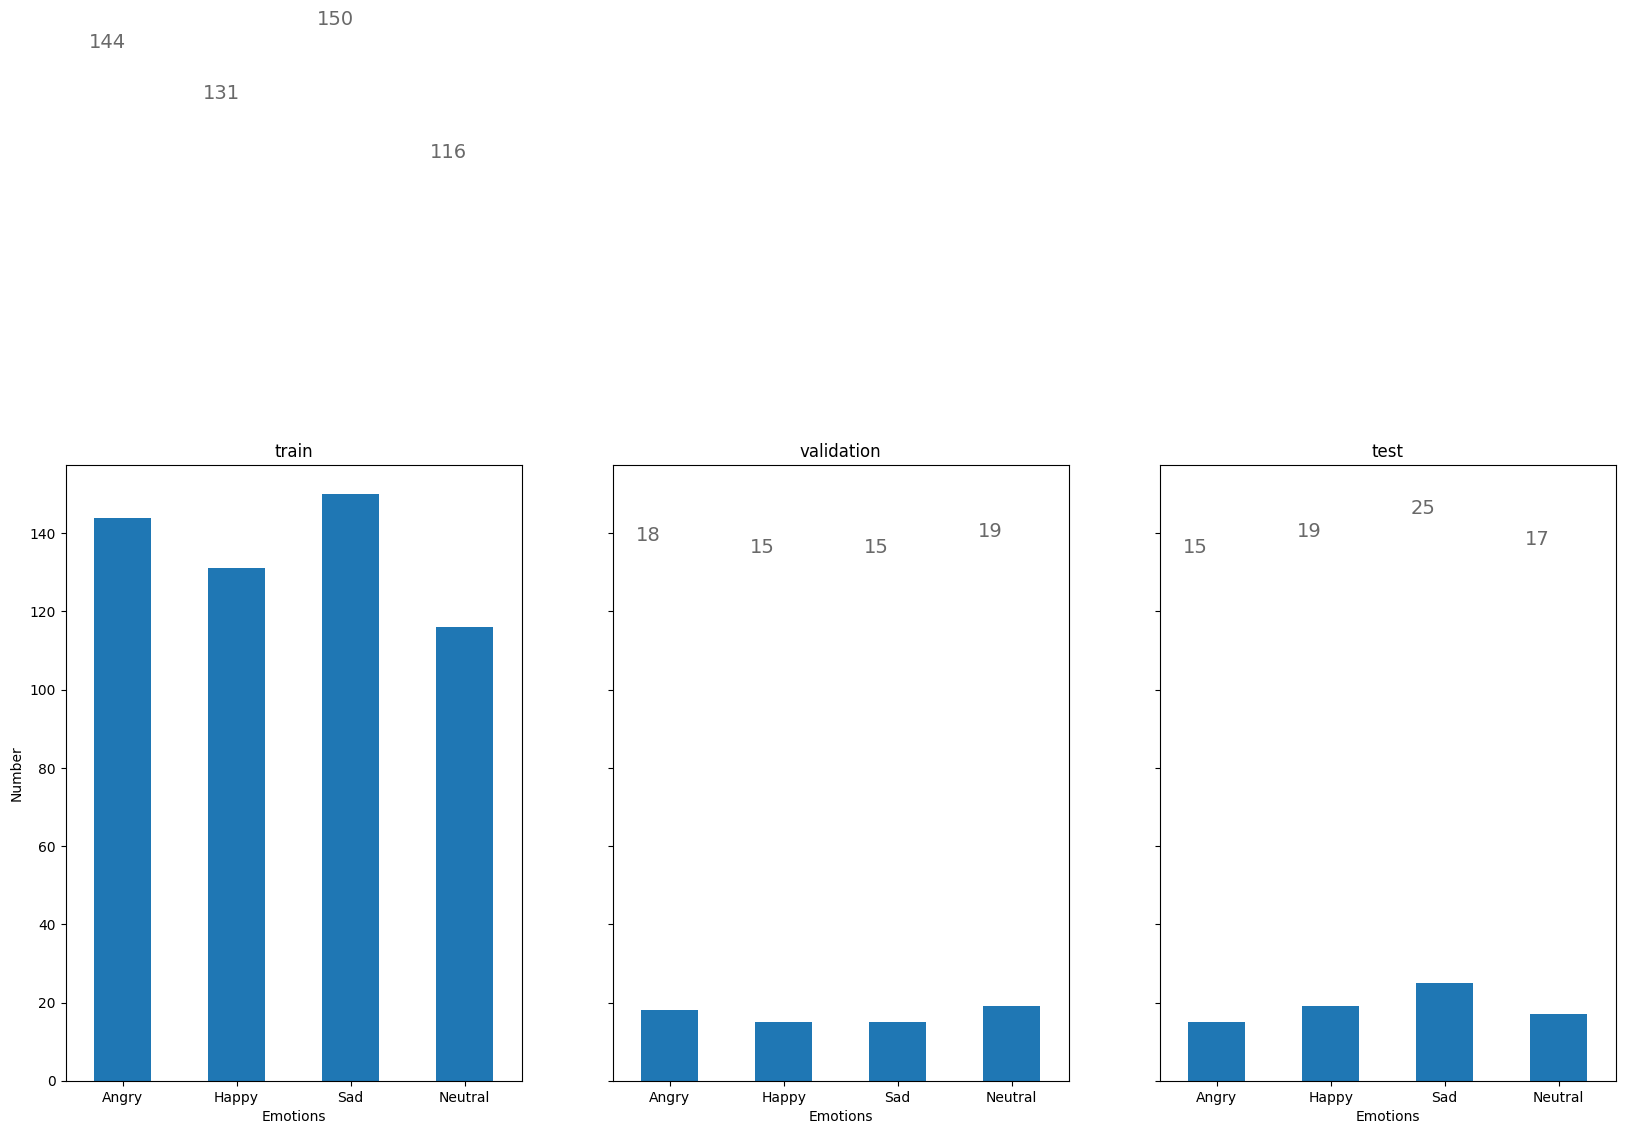

In [223]:
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [224]:
ck_data = pd.read_csv('../Dataset/Dataset/CK+/ckextended.csv')
#check data shape
ck_data.shape

(920, 3)

In [225]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7:'Contempt'}
emotion_counts = ck_data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Neutral,593
1,Happy,69
2,Contempt,18
3,Angry,45
4,Digust,59
5,Sad,28
6,Fear,25
7,Surprise,83


In [226]:
ck_data['emotion'] = ck_data['emotion'].rank(method='dense').astype(int) - 1

In [227]:
ck_data = ck_data[~ck_data['emotion'].isin([1, 2, 5, 7])] 
distinct_values = ck_data['emotion'].unique()
print(distinct_values)

[6 3 0 4]


In [228]:
emotion_map = {0: 'Angry', 3: 'Happy', 4: 'Sad', 6: 'Neutral'}

emotion_mapping = {0: 0, 3: 1, 4: 2, 6: 3}

ck_data.loc[:, 'emotion'] = ck_data['emotion'].map(emotion_mapping).astype(np.int32)

In [229]:
ck_data.emotion.value_counts()

emotion
3    593
1     69
0     45
2     28
Name: count, dtype: int64

In [230]:
df_majority = ck_data[ck_data['emotion'] == 3]
df_minority_1 = ck_data[ck_data['emotion'] == 1]
df_minority_0 = ck_data[ck_data['emotion'] == 0]
df_minority_2 = ck_data[ck_data['emotion'] == 2]

df_majority_downsampled = df_majority.sample(n=max(len(df_minority_1), len(df_minority_0), len(df_minority_2)),
                                              random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority_1, df_minority_0, df_minority_2])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [231]:
df_balanced.emotion.value_counts()

emotion
3    69
1    69
0    45
2    28
Name: count, dtype: int64

In [232]:
data_train = df_balanced[df_balanced['Usage']=='Training'].copy()
data_val = df_balanced[df_balanced['Usage'] == 'PublicTest'].copy()
data_test = df_balanced[df_balanced['Usage'] == 'PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (163, 3), 
validation shape: (20, 3), 
test shape: (28, 3)


In [233]:
data_train = pd.concat([data_train, szu_train], ignore_index=True)
data_val = pd.concat([data_val, szu_val], ignore_index=True)
data_test = pd.concat([data_test, szu_test], ignore_index=True)

In [234]:
data_train['Usage'] = data_train['Usage'].fillna('Training')
data_train

,emotion,pixels,Usage
0,3,9 10 10 7 9 6 7 12 22 19 22 22 21 23 22 21 16 ...,Training
1,0,191 202 78 44 37 42 35 31 45 73 68 76 79 96 16...,Training
2,0,64 66 70 72 67 35 18 10 20 37 65 78 104 127 15...,Training
3,1,79 85 82 31 19 16 14 15 13 20 13 6 2 4 31 92 1...,Training
4,2,168 172 187 182 185 168 154 95 151 253 210 135...,Training
...,...,...,...
536,0,49 45 37 59 119 158 166 169 166 172 169 171 17...,Training
537,2,41 37 36 29 29 40 57 112 131 141 153 152 154 1...,Training
538,3,36 30 30 49 73 104 116 116 119 122 125 129 134...,Training
539,1,44 23 19 17 32 83 95 102 101 107 109 113 118 1...,Training


In [235]:
data_val['Usage'] = data_val['Usage'].fillna('PublicTest')
data_val

,emotion,pixels,Usage
0,3,17 18 19 21 25 4 24 27 36 29 27 51 58 62 52 53...,PublicTest
1,3,174 146 59 59 57 46 44 37 34 27 22 16 25 36 63...,PublicTest
2,2,47 11 5 6 7 9 9 8 17 26 44 78 109 165 171 174 ...,PublicTest
3,0,39 26 17 10 9 14 29 13 20 11 24 16 14 15 15 19...,PublicTest
4,1,12 13 9 5 4 6 10 28 65 18 17 23 24 27 33 31 66...,PublicTest
...,...,...,...
62,2,22 20 16 21 18 20 26 33 38 37 56 36 58 62 61 7...,PublicTest
63,0,28 31 32 25 26 27 26 26 46 70 86 97 109 115 11...,PublicTest
64,3,15 15 23 25 53 89 99 102 108 110 116 118 126 1...,PublicTest
65,1,10 11 14 15 15 13 16 16 60 75 80 94 104 111 11...,PublicTest


In [236]:
data_test['Usage'] = data_test['Usage'].fillna('PrivateTest')
data_test

,emotion,pixels,Usage
0,2,159 17 11 7 6 11 22 35 49 68 77 80 80 89 82 10...,PrivateTest
1,1,87 84 79 47 14 10 8 9 16 29 29 24 27 67 107 10...,PrivateTest
2,2,31 21 26 30 30 23 33 37 25 30 47 43 49 81 172 ...,PrivateTest
3,3,18 22 15 13 20 17 11 14 19 22 35 40 37 28 38 5...,PrivateTest
4,1,255 255 251 87 22 18 18 24 20 27 34 36 39 49 2...,PrivateTest
...,...,...,...
71,3,54 35 32 40 44 54 83 115 113 140 146 149 150 1...,PrivateTest
72,2,65 59 52 46 53 49 60 73 96 93 108 124 132 144 ...,PrivateTest
73,1,36 33 57 86 99 112 120 121 122 127 129 131 138...,PrivateTest
74,3,16 16 18 17 16 12 14 18 20 32 43 55 61 71 87 9...,PrivateTest


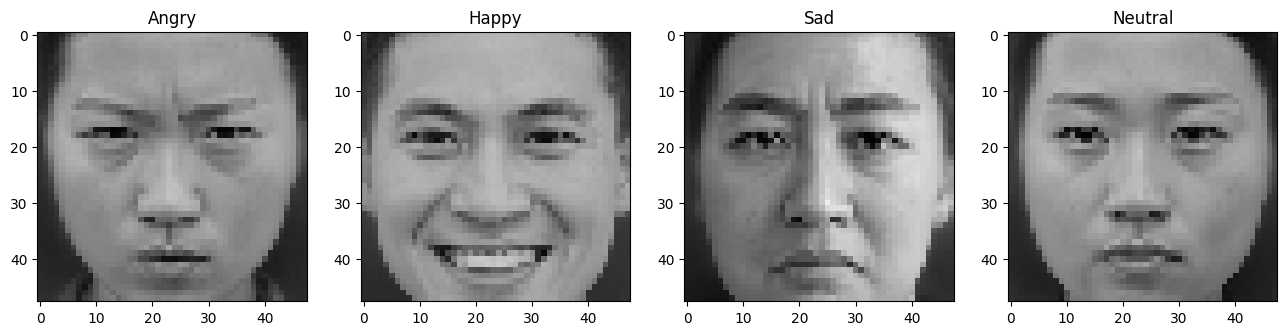

In [237]:
emotion_map = {0: 'Angry',  1: 'Happy', 2: 'Sad', 3: 'Neutral'}

plt.figure(0, figsize=(16,10))
for i in range(4):  # Adjust range to match emotion indices
    face = data_train[data_train['emotion'] == i].sample(n=1).iloc[0]  # Use i directly without subtracting 1
    img = row3image(face, emotion_map)
    plt.subplot(2, 4, i+1)  # Increment i by 1 to start subplot index from 1
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [275]:
num_classes = 4
width, height = 48, 48
num_epochs = 100
batch_size = 32

train_X, train_Y = CRNO(szu_train, "train") #training data
val_X, val_Y     = CRNO(szu_val, "val") #validation data
test_X, test_Y   = CRNO(szu_test, "test") #test data

train _X shape: (378, 48, 48, 1) train _Y shape: (378, 4)
val _X shape: (47, 48, 48, 1) val _Y shape: (47, 4)
test _X shape: (48, 48, 48, 1) test _Y shape: (48, 4)


In [276]:
from tensorflow.keras.models import load_model

base_model = load_model('./Model/FER_v3_w_CK+.h5')

In [277]:
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_27 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_28 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 48, 48, 64)       

In [278]:
for layer in base_model.layers:
    layer.trainable = False

In [279]:
base_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [280]:
history = base_model.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
11/11 - 3s - loss: 0.2841 - accuracy: 0.9206 - val_loss: 0.2749 - val_accuracy: 0.9362 - 3s/epoch - 274ms/step
Epoch 2/100
11/11 - 2s - loss: 0.2768 - accuracy: 0.9153 - val_loss: 0.2749 - val_accuracy: 0.9362 - 2s/epoch - 195ms/step
Epoch 3/100
11/11 - 2s - loss: 0.2637 - accuracy: 0.9312 - val_loss: 0.2749 - val_accuracy: 0.9362 - 2s/epoch - 195ms/step
Epoch 4/100
11/11 - 2s - loss: 0.2754 - accuracy: 0.9101 - val_loss: 0.2749 - val_accuracy: 0.9362 - 2s/epoch - 201ms/step
Epoch 5/100
11/11 - 2s - loss: 0.2843 - accuracy: 0.9153 - val_loss: 0.2749 - val_accuracy: 0.9362 - 2s/epoch - 208ms/step
Epoch 6/100
11/11 - 2s - loss: 0.2698 - accuracy: 0.9286 - val_loss: 0.2749 - val_accuracy: 0.9362 - 2s/epoch - 196ms/step


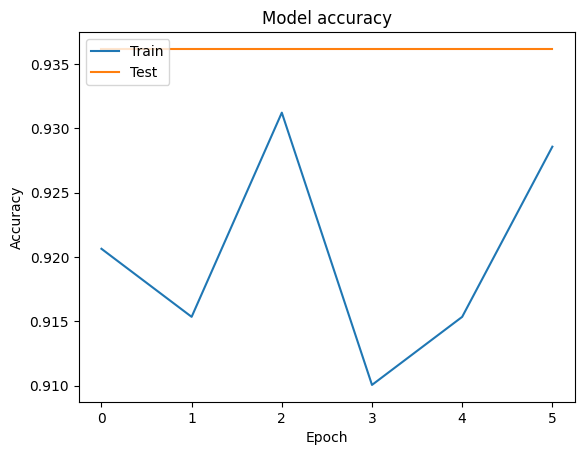

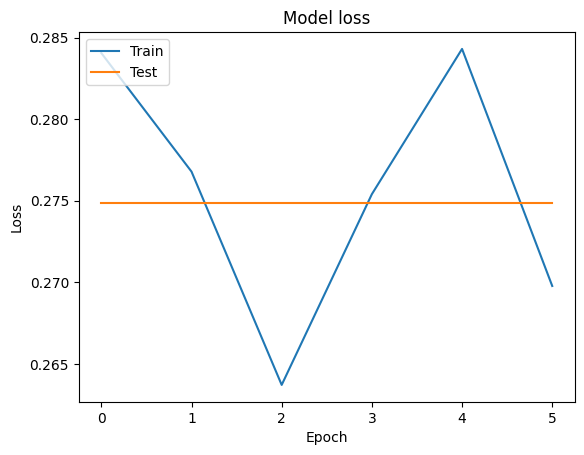

In [281]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [282]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(base_model.predict(test_X), axis=1)
vgg_16_score = accuracy_score(test_true, test_pred)
print("1.VGG-16 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

2/2 [==============================] - 0s 98ms/step
1.VGG-16 CNN Model Accuracy on test set: 0.9375


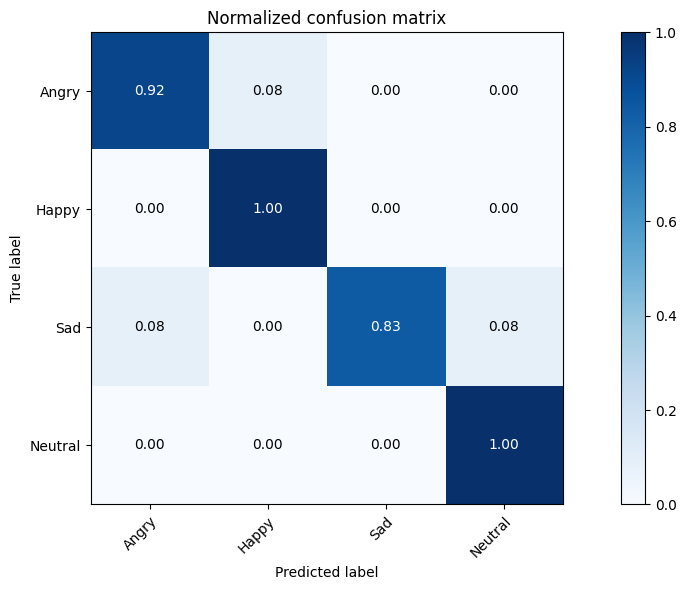

In [283]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
base_model.save('../Recognition/Model/FER_v3_w_CK+_w_SZU.h5')